# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/EhWeqeQsh-9Mr1fneZc9_0sBOBzEdXngvxFJtAlIa-eAgA?e=8ukWwa). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ).

# Step 1: Problem formulation and data collection

## Business problem.
A travel booking site wants to improve user experience by warning customers when their chosen flight is likely to be delayed on arrival due to conditions that can be inferred before booking (schedule, route, seasonality, prevailing weather by airport, etc.). The feature should focus on the busiest US airports and major carriers to maximise user impact.

## Business goal & success metric.
Reduce the proportion of customers surprised by delays. We will:

maximise precision at a chosen recall on the positive class (delayed ≥15 min, i.e. ArrDel15=1) to avoid over-warning;

report PR-AUC and F1 as primary model metrics (class imbalance aware);

track operational KPI: percentage of delayed flights correctly warned (recall) at or above a business-agreed threshold (e.g., ≥0.70), while keeping the false-alert rate (1 − precision) acceptable (e.g., ≤0.30).


### 1. Determine if and why ML is an appropriate solution to deploy.

Given flight scheduling info (date parts, route, carrier, planned departure time) and ex-ante signals (holiday flags, historical/typical weather by airport/day), predict whether a flight will arrive delayed by ≥15 minutes (is_delay ∈ {0,1}).

### 2. Formulate the business problem, success metrics, and desired ML output.

Supervised binary classification. Initial baseline with logistic regression; later feature engineering (holidays + weather) to improve performance; metrics:  confusion matrix, ROC, PR-AUC, precision/recall/F1.

### 3. Identify the type of ML problem you’re dealing with.

Exclude realized delay fields (ArrDelay, DepDelay, *Delay*Minutes, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay) from features. Only use variables knowable pre-departure or typical/lagged weather summaries.

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [4]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [ ]:
# Setup & Imports 
import os, sys, time, re, glob, warnings, subprocess
from pathlib import Path
from zipfile import ZipFile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

# Relative paths
project_root = Path.cwd().resolve().parent if (Path.cwd()/ 'data').exists() is False else Path.cwd()
DATA_DIR     = project_root / 'data'
ZIPS_DIR     = DATA_DIR / 'zips'
EXTRACT_DIR  = DATA_DIR / 'extracted'
EXTERNAL_DIR = DATA_DIR / 'external'   # for weather file daily-summaries.csv

# Ensure folders exist
for p in [DATA_DIR, ZIPS_DIR, EXTRACT_DIR, EXTERNAL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Project root:", project_root)
print("Data dir:", DATA_DIR)

# Utility: list files with a pattern
def list_files(root: Path, pattern: str):
    return sorted([Path(p) for p in glob.glob(str(root / pattern), recursive=True)])

# Utility: safe unzip (idempotent)
def unzip_to_folder(zip_path: Path, out_dir: Path):
    try:
        with ZipFile(zip_path, 'r') as zf:
            zf.extractall(out_dir)
        return True
    except Exception as e:
        print(f"[WARN] Failed to extract {zip_path.name}: {e}")
        return False


Project root: C:\Users\wante\OneDrive\Pictures\project_root
Data dir: C:\Users\wante\OneDrive\Pictures\project_root\data


#### Extract CSV files from ZIP files

In [ ]:

# Count top-level ZIPs in data/zips
zip_files = list_files(ZIPS_DIR, "*.zip")
print(f"Found {len(zip_files)} ZIP files in {ZIPS_DIR}")

# 1 Extract top-level ZIPs into EXTRACT_DIR
start = time.time()
ok = 0
for z in zip_files:
    if unzip_to_folder(z, EXTRACT_DIR):
        ok += 1
print(f"Extracted {ok}/{len(zip_files)} top-level ZIPs in {round(time.time()-start, 2)}s.")

#  Recursively extract inner ZIPs found under EXTRACT_DIR
from zipfile import BadZipFile

def rglob_ext(root: Path, ext: str):
    ext = ext.lower()
    return [p for p in root.rglob("*") if p.suffix.lower() == ext]

processed = set()
rounds = 0
t0 = time.time()

while True:
    inner_zips = [p for p in rglob_ext(EXTRACT_DIR, ".zip") if p.resolve() not in processed]
    if not inner_zips:
        break
    rounds += 1
    print(f"\n[Round {rounds}] Number of inner ZIP files found: {len(inner_zips)}")
    # preview first 10
    for n in inner_zips[:10]:
        print(" ", n)
    # extract this round
    for zp in inner_zips:
        try:
            with ZipFile(zp, "r") as zf:
                zf.extractall(EXTRACT_DIR)
        except BadZipFile:
            print(f"[WARN] Not a ZIP (skipped): {zp}")
        except Exception as e:
            print(f"[WARN] Failed to extract {zp}: {e}")
        finally:
            processed.add(zp.resolve())

print(f"\nDone recursive extraction in {round(time.time()-t0, 2)}s across {rounds} round(s).")

# 3) Count extracted CSVs 
csv_files = [p for p in EXTRACT_DIR.rglob("*") if p.suffix.lower() == ".csv"]
print(f"Found {len(csv_files)} CSV files under {EXTRACT_DIR}")
print("Sample CSVs:")
for p in csv_files[:10]:
    print(" ", p)


Found 1 ZIP files in C:\Users\wante\OneDrive\Pictures\project_root\data\zips
Extracted 1/1 top-level ZIPs in 1.02s.

[Round 1] Number of inner ZIP files found: 60
  C:\Users\wante\OneDrive\Pictures\project_root\data\extracted\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
  C:\Users\wante\OneDrive\Pictures\project_root\data\extracted\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip
  C:\Users\wante\OneDrive\Pictures\project_root\data\extracted\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip
  C:\Users\wante\OneDrive\Pictures\project_root\data\extracted\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip
  C:\Users\wante\OneDrive\Pictures\project_root\data\extracted\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip
  C:\Users\wante\OneDrive\Pictures\project_root\data\extracted\data_compressed\On_Time_Re

Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [9]:
from IPython.display import IFrame, display, HTML

readme_html = EXTRACT_DIR / "readme.html"
if readme_html.exists():
    display(IFrame(src=os.path.relpath(readme_html), width=1000, height=600))
else:
    print("[INFO] readme.html not found in extracted folder.")


#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [15]:
# Try to locate the example file mentioned: *2018_9.csv
# Fall back to the first monthly CSV if that exact file isn't present.
candidate = list_files(EXTRACT_DIR, "**/*2018_9*.csv")
sample_csv = candidate[0] if candidate else (csv_files[0] if csv_files else None)
assert sample_csv is not None, "No CSVs found after extraction — check your ZIPs."

df_temp = pd.read_csv(sample_csv, low_memory=False)
print("Sample file:", sample_csv.name)
print("Shape:", df_temp.shape)
print("Columns:", list(df_temp.columns)[:20], "... (truncated)")





Sample file: On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv
Shape: (585749, 110)
Columns: ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'DOT_ID_Reporting_Airline', 'IATA_CODE_Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac'] ... (truncated)


**Question**: Print the row and column length in the dataset, and print the column names.

In [ ]:
# Shape (rows, columns)
rows, cols = df_temp.shape
print(f"Rows: {rows}, Columns: {cols}")

# Column names (one per line)
print("Column names:")
for col in df_temp.columns:
    print(col)



Rows: 585749, Columns: 110
Column names:
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1Wheel

**Question**: Print the first 10 rows of the dataset.  

In [14]:
display(df_temp.head(10))

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1307.0,-8.0,0.0,0.0,-1.0,1300-1359,32.0,1339.0,1627.0,4.0,1629,1631.0,2.0,2.0,0.0,0.0,1600-1659,0.0,NaN,0.0,134.0,144.0,108.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1307.0,-8.0,0.0,0.0,-1.0,1300-1359,21.0,1328.0,1610.0,4.0,1629,1614.0,-15.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,127.0,102.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1310.0,-5.0,0.0,0.0,-1.0,1300-1359,19.0,1329.0,1613.0,5.0,1629,1618.0,-11.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,128.0,104.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1313.0,-2.0,0.0,0.0,-1.0,1300-1359,14.0,1327.0,1613.0,4.0,1629,1617.0,-12.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,124.0,106.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1311.0,-4.0,0.0,0.0,-1.0,1300-1359,15.0,1326.0,1614.0,5.0,1629,1619.0,-10.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,128.0,108.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [ ]:
print("The column names are:")
print("#########")
for col in df_temp.columns:
    print(col)




The column names are:
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1T

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [ ]:
# Columns containing 'Del' 
del_cols = [c for c in df_temp.columns if re.search(r'del', c, flags=re.I)]
print("Columns containing 'Del':", del_cols)

Columns containing 'Del': ['DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'DivArrDelay']


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [17]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", df_temp.shape[0], " and ", df_temp.shape[1])
print("The years in this dataset are: ", sorted(pd.to_datetime(df_temp['FlightDate'], errors='coerce').dropna().dt.year.unique()))
print("The months covered in this dataset are: ", sorted(pd.to_datetime(df_temp['FlightDate'], errors='coerce').dropna().dt.month.unique()))
print("The date range for data is :" , pd.to_datetime(df_temp['FlightDate'], errors='coerce').dropna().min(), " to ", pd.to_datetime(df_temp['FlightDate'], errors='coerce').dropna().max())
print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].dropna().unique()))
print("The Origin airports covered are: ", list(df_temp['Origin'].dropna().unique()))
print("The Destination airports covered are: ", list(df_temp['Dest'].dropna().unique()))


The #rows and #columns are  585749  and  110
The years in this dataset are:  [np.int32(2018)]
The months covered in this dataset are:  [np.int32(9)]
The date range for data is : 2018-09-01 00:00:00  to  2018-09-30 00:00:00
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', '

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [18]:
# Counts for all Origin and Destination airports
counts = pd.concat(
    [
        df_temp['Origin'].value_counts().rename('Origin'),
        df_temp['Dest'].value_counts().rename('Destination')
    ],
    axis=1
).fillna(0).astype(int)

display(counts) 




,Origin,Destination
ATL,31525,31521
ORD,28257,28250
DFW,22802,22795
DEN,19807,19807
CLT,19655,19654
...,...,...
PPG,8,8
HGR,8,8
OGD,8,8
STC,5,5


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [ ]:
# Top 15 Origin airports (by number of departing flights)
top15_origin = df_temp['Origin'].value_counts().head(15)
display(top15_origin.to_frame('flights_from_origin'))

# Top 15 Destination airports (by number of arriving flights)
top15_dest = df_temp['Dest'].value_counts().head(15)
display(top15_dest.to_frame('flights_to_destination'))




,flights_from_origin
Origin,
ATL,31525
ORD,28257
DFW,22802
DEN,19807
CLT,19655
LAX,17875
SFO,14332
IAH,14210
LGA,13850


,flights_to_destination
Dest,
ATL,31521
ORD,28250
DFW,22795
DEN,19807
CLT,19654
LAX,17873
SFO,14348
IAH,14203
LGA,13850


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

Yes—but only probabilistically. We can train a supervised binary classifier (e.g., logistic regression or XGBoost) to estimate the probability that a flight will arrive delayed ≥ 15 minutes.

For a fair, real-world setup we must restrict inputs to features known before departure (date parts, route, carrier, scheduled dep time, typical/lagged weather, holidays). We must exclude leakage variables that reveal realized outcomes (ArrDelay, DepDelay, *DelayMinutes*, WeatherDelay, etc.).

Because delays are relatively imbalanced (fewer delays than on-time), we’ll evaluate with precision/recall, PR-AUC, F1, and tune the decision threshold to the business goal (e.g., high precision to avoid over-warning, or higher recall to catch more true delays).

Bottom line: the model can predict with useful accuracy and guide customer messaging, but not perfectly, because some factors (sudden weather, ATC, operational issues) are inherently unpredictable.

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [20]:
# Count + show pre-flight features
pre_flight_cols = [
    'Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
    'Reporting_Airline','Origin','OriginState','Dest','DestState',
    'CRSDepTime','Distance','DistanceGroup'
]
print("Pre-flight features count:", len(pre_flight_cols))
print(pre_flight_cols)


Pre-flight features count: 14
['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState', 'CRSDepTime', 'Distance', 'DistanceGroup']


In [21]:
# Discover CSVs 
csv_files = [p for p in EXTRACT_DIR.rglob("*.csv")]
print(f"Discovered {len(csv_files)} CSVs under {EXTRACT_DIR}")

def combine_csv(csv_paths, filter_cols, subset_cols, subset_vals, out_csv: Path, chunksize=200_000):
    """
    Combine many monthly CSVs into a single filtered CSV (memory-safe, chunked).
    - Keeps only filter_cols
    - Filters rows by subset_cols[i] ∈ subset_vals[i]
    """
    assert len(subset_cols) == len(subset_vals), "subset_cols and subset_vals must align"

    out_csv.parent.mkdir(parents=True, exist_ok=True)
    if out_csv.exists():
        out_csv.unlink()

    total_rows = 0
    header_written = False

    for path in csv_paths:
        try:
            for chunk in pd.read_csv(path, chunksize=chunksize, low_memory=False):
                # Keep only requested columns that exist in this chunk
                present = [c for c in filter_cols if c in chunk.columns]
                if not present:
                    continue
                df = chunk[present].copy()

                # Row filters
                for col, allowed in zip(subset_cols, subset_vals):
                    if col in df.columns:
                        df = df[df[col].isin(allowed)]
                if df.empty:
                    continue

                # Append to output
                df.to_csv(out_csv, mode='a', index=False, header=(not header_written))
                header_written = True
                total_rows += len(df)

        except Exception as e:
            print(f"[WARN] Skipping {path.name}: {e}")

    print(f"Wrote {total_rows:,} rows → {out_csv}")
    return total_rows

# Columns to keep 
filter_cols = [
    'Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
    'Reporting_Airline','Origin','OriginState','Dest','DestState',
    'CRSDepTime','DepDelayMinutes','DepartureDelayGroups','Cancelled','Diverted',
    'Distance','DistanceGroup','ArrDelay','ArrDelayMinutes','ArrDel15','AirTime'
]

# Row filters
subset_cols = ['Origin', 'Dest', 'Reporting_Airline']
subset_vals = [
    ['ATL','ORD','DFW','DEN','CLT','LAX','IAH','PHX','SFO'],  # origins
    ['ATL','ORD','DFW','DEN','CLT','LAX','IAH','PHX','SFO'],  # destinations
    ['UA','OO','WN','AA','DL']                                # airlines
]

# Run combine
start = time.time()
combined_v1_path = DATA_DIR / "combined_csv_v1.csv"
_ = combine_csv(csv_files, filter_cols, subset_cols, subset_vals, combined_v1_path)
print(f"csv's merged in {round((time.time()-start)/60, 2)} minutes")


Discovered 60 CSVs under C:\Users\wante\OneDrive\Pictures\project_root\data\extracted
Wrote 1,658,130 rows → C:\Users\wante\OneDrive\Pictures\project_root\data\combined_csv_v1.csv
csv's merged in 2.83 minutes


Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

#### Load dataset

Load the combined dataset.

In [23]:
from pathlib import Path
import pandas as pd

# Look for a combined CSV under data/
candidates = [p for p in DATA_DIR.rglob("*.csv") if "combined" in p.name.lower()]
if not candidates:
    raise FileNotFoundError("Couldn't find a combined CSV under data/. Make sure you saved it there.")

# Pick the most recently modified combined CSV
combined_path = max(candidates, key=lambda p: p.stat().st_mtime)
print("Using combined dataset:", combined_path)

# Load
data = pd.read_csv(combined_path, low_memory=False)

# Tidy key columns
if 'ArrDel15' in data.columns:
    data = data.rename(columns={'ArrDel15': 'is_delay'})
if 'FlightDate' in data.columns:
    data['FlightDate'] = pd.to_datetime(data['FlightDate'], errors='coerce')

print("Shape:", data.shape)
display(data.head(5))


Using combined dataset: C:\Users\wante\OneDrive\Pictures\project_root\data\combined_csv_v1.csv
Shape: (1658130, 22)


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,DepDelayMinutes,DepartureDelayGroups,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,is_delay,AirTime
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,TX,2145,0.0,-1.0,0.0,0.0,689.0,3,-20.0,0.0,0.0,99.0
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,GA,945,0.0,-1.0,0.0,0.0,731.0,3,-3.0,0.0,0.0,98.0
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,CO,1855,0.0,-1.0,0.0,0.0,1199.0,5,-7.0,0.0,0.0,174.0
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,AZ,1634,0.0,-1.0,0.0,0.0,1587.0,7,-4.0,0.0,0.0,233.0
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,GA,700,0.0,-1.0,0.0,0.0,1587.0,7,-13.0,0.0,0.0,179.0


Print the first 5 records.

In [24]:
# First 5 records
data.head(5)


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,DepDelayMinutes,DepartureDelayGroups,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,is_delay,AirTime
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,TX,2145,0.0,-1.0,0.0,0.0,689.0,3,-20.0,0.0,0.0,99.0
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,GA,945,0.0,-1.0,0.0,0.0,731.0,3,-3.0,0.0,0.0,98.0
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,CO,1855,0.0,-1.0,0.0,0.0,1199.0,5,-7.0,0.0,0.0,174.0
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,AZ,1634,0.0,-1.0,0.0,0.0,1587.0,7,-4.0,0.0,0.0,233.0
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,GA,700,0.0,-1.0,0.0,0.0,1587.0,7,-13.0,0.0,0.0,179.0


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [ ]:
# to answer above questions, complete the following code
if 'FlightDate' in data.columns:
    date_series = pd.to_datetime(data['FlightDate'], errors='coerce')
elif {'Year','Month','DayofMonth'}.issubset(data.columns):
    date_series = pd.to_datetime(
        dict(year=data['Year'], month=data['Month'], day=data['DayofMonth']),
        errors='coerce'
    )
else:
    date_series = pd.to_datetime(pd.Series([], dtype=str))

# Years & months
years  = (sorted(date_series.dt.year.dropna().unique().tolist())
          if len(date_series) else
          sorted(data['Year'].dropna().unique().tolist()) if 'Year' in data.columns else [])
months = (sorted(date_series.dt.month.dropna().unique().tolist())
          if len(date_series) else
          sorted(data['Month'].dropna().unique().tolist()) if 'Month' in data.columns else [])

# Airline / airport columns 
airline_col = 'Reporting_Airline' if 'Reporting_Airline' in data.columns else (
              'OP_CARRIER' if 'OP_CARRIER' in data.columns else None)

origin_col  = 'Origin' if 'Origin' in data.columns else None
dest_col    = 'Dest'   if 'Dest'   in data.columns else None

print("The #rows and #columns are ", data.shape[0], " and ", data.shape[1])
print("The years in this dataset are: ", years)
print("The months covered in this dataset are: ", months)
if len(date_series):
    print("The date range for data is :", date_series.min(), " to ", date_series.max())
else:
    print("The date range for data is : (unavailable — no date columns)")

print("The airlines covered in this dataset are: ",
      sorted(data[airline_col].dropna().unique().tolist()) if airline_col else "N/A")

print("The Origin airports covered are: ",
      sorted(data[origin_col].dropna().unique().tolist()) if origin_col else "N/A")

print("The Destination airports covered are: ",
      sorted(data[dest_col].dropna().unique().tolist()) if dest_col else "N/A")


The #rows and #columns are  1658130  and  22
The years in this dataset are:  [2014, 2015, 2016, 2017, 2018]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is : 2014-01-01 00:00:00  to  2018-12-31 00:00:00
The airlines covered in this dataset are:  ['AA', 'DL', 'OO', 'UA', 'WN']
The Origin airports covered are:  ['ATL', 'CLT', 'DEN', 'DFW', 'IAH', 'LAX', 'ORD', 'PHX', 'SFO']
The Destination airports covered are:  ['ATL', 'CLT', 'DEN', 'DFW', 'IAH', 'LAX', 'ORD', 'PHX', 'SFO']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

data.rename(columns=<CODE>, inplace=True) # Enter your code here

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [26]:
# Ensure target exists and is clean 0/1 integers
if 'is_delay' not in data.columns:
    if 'ArrDel15' in data.columns:
        data.rename(columns={'ArrDel15': 'is_delay'}, inplace=True)
    else:
        raise KeyError("Neither 'is_delay' nor 'ArrDel15' found in the dataset.")

# Coerce to numeric and drop rows with missing target
data['is_delay'] = pd.to_numeric(data['is_delay'], errors='coerce').astype('Int64')
before = len(data)
data = data.dropna(subset=['is_delay']).copy()
after = len(data)
data['is_delay'] = data['is_delay'].astype(int)

print(f"Dropped {before - after} rows with missing target.")
print("Target counts:\n", data['is_delay'].value_counts())
print("Target distribution (%):\n", (data['is_delay'].value_counts(normalize=True)*100).round(2))


Dropped 22540 rows with missing target.
Target counts:
 is_delay
0    1292258
1     343332
Name: count, dtype: int64
Target distribution (%):
 is_delay
0    79.01
1    20.99
Name: proportion, dtype: float64


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [28]:
# Columns to check for missing values
cols_to_check = [c for c in ['is_delay', 'AirTime', 'ArrDelay', 'ArrDelayMinutes'] if c in data.columns]

# Rows that have any NA in those columns
missing_mask = data[cols_to_check].isnull().any(axis=1)

n_missing = int(missing_mask.sum())
n_total   = len(data)

print(f"Rows with missing arrival-delay/airtime fields: {n_missing} out of {n_total} "
      f"({(n_missing/n_total*100):.2f}%)")

# Keep only rows WITHOUT missing values in the selected columns (note the ~)
data = data[~missing_mask].copy()
print("New shape after drop:", data.shape)

# (Optional) ensure target is clean int
if 'is_delay' in data.columns:
    data['is_delay'] = pd.to_numeric(data['is_delay'], errors='coerce').astype(int)


Rows with missing arrival-delay/airtime fields: 0 out of 1635590 (0.00%)
New shape after drop: (1635590, 22)


Get the hour of the day in 24-hour time format from CRSDepTime.

In [29]:
data['DepHourofDay'] = pd.to_numeric(data['CRSDepTime'], errors='coerce')\
    .apply(lambda v: int(f"{int(v):04d}"[:2]) if pd.notnull(v) else np.nan)\
    .astype('Int64')


## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

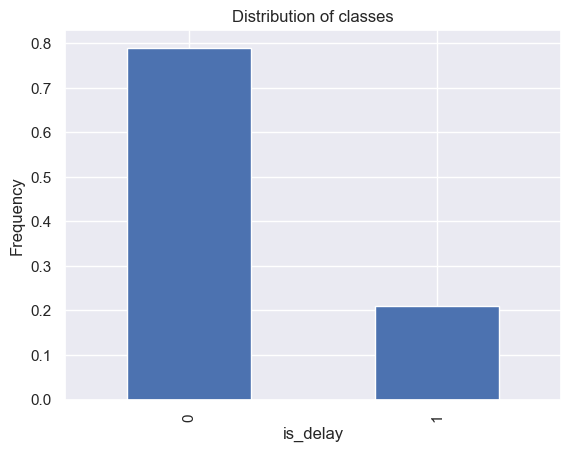

In [30]:
# Distribution of classes (0 = no delay, 1 = delay)
(data.groupby('is_delay').size() / len(data)).plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()


**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

* The dataset is **imbalanced**: roughly **~79–80%** flights are **on time (0)** and **~20–21%** are **delayed (1)**.
* **Implications:**

  * Plain **accuracy will be misleading** (a dummy “always 0” gets ~80%).
  * Use imbalance-aware metrics (**precision/recall, F1, PR-AUC**) and **stratified** train/test splits.
  * Consider **class_weight='balanced'** (or resampling) and **threshold tuning** to meet business goals.


**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

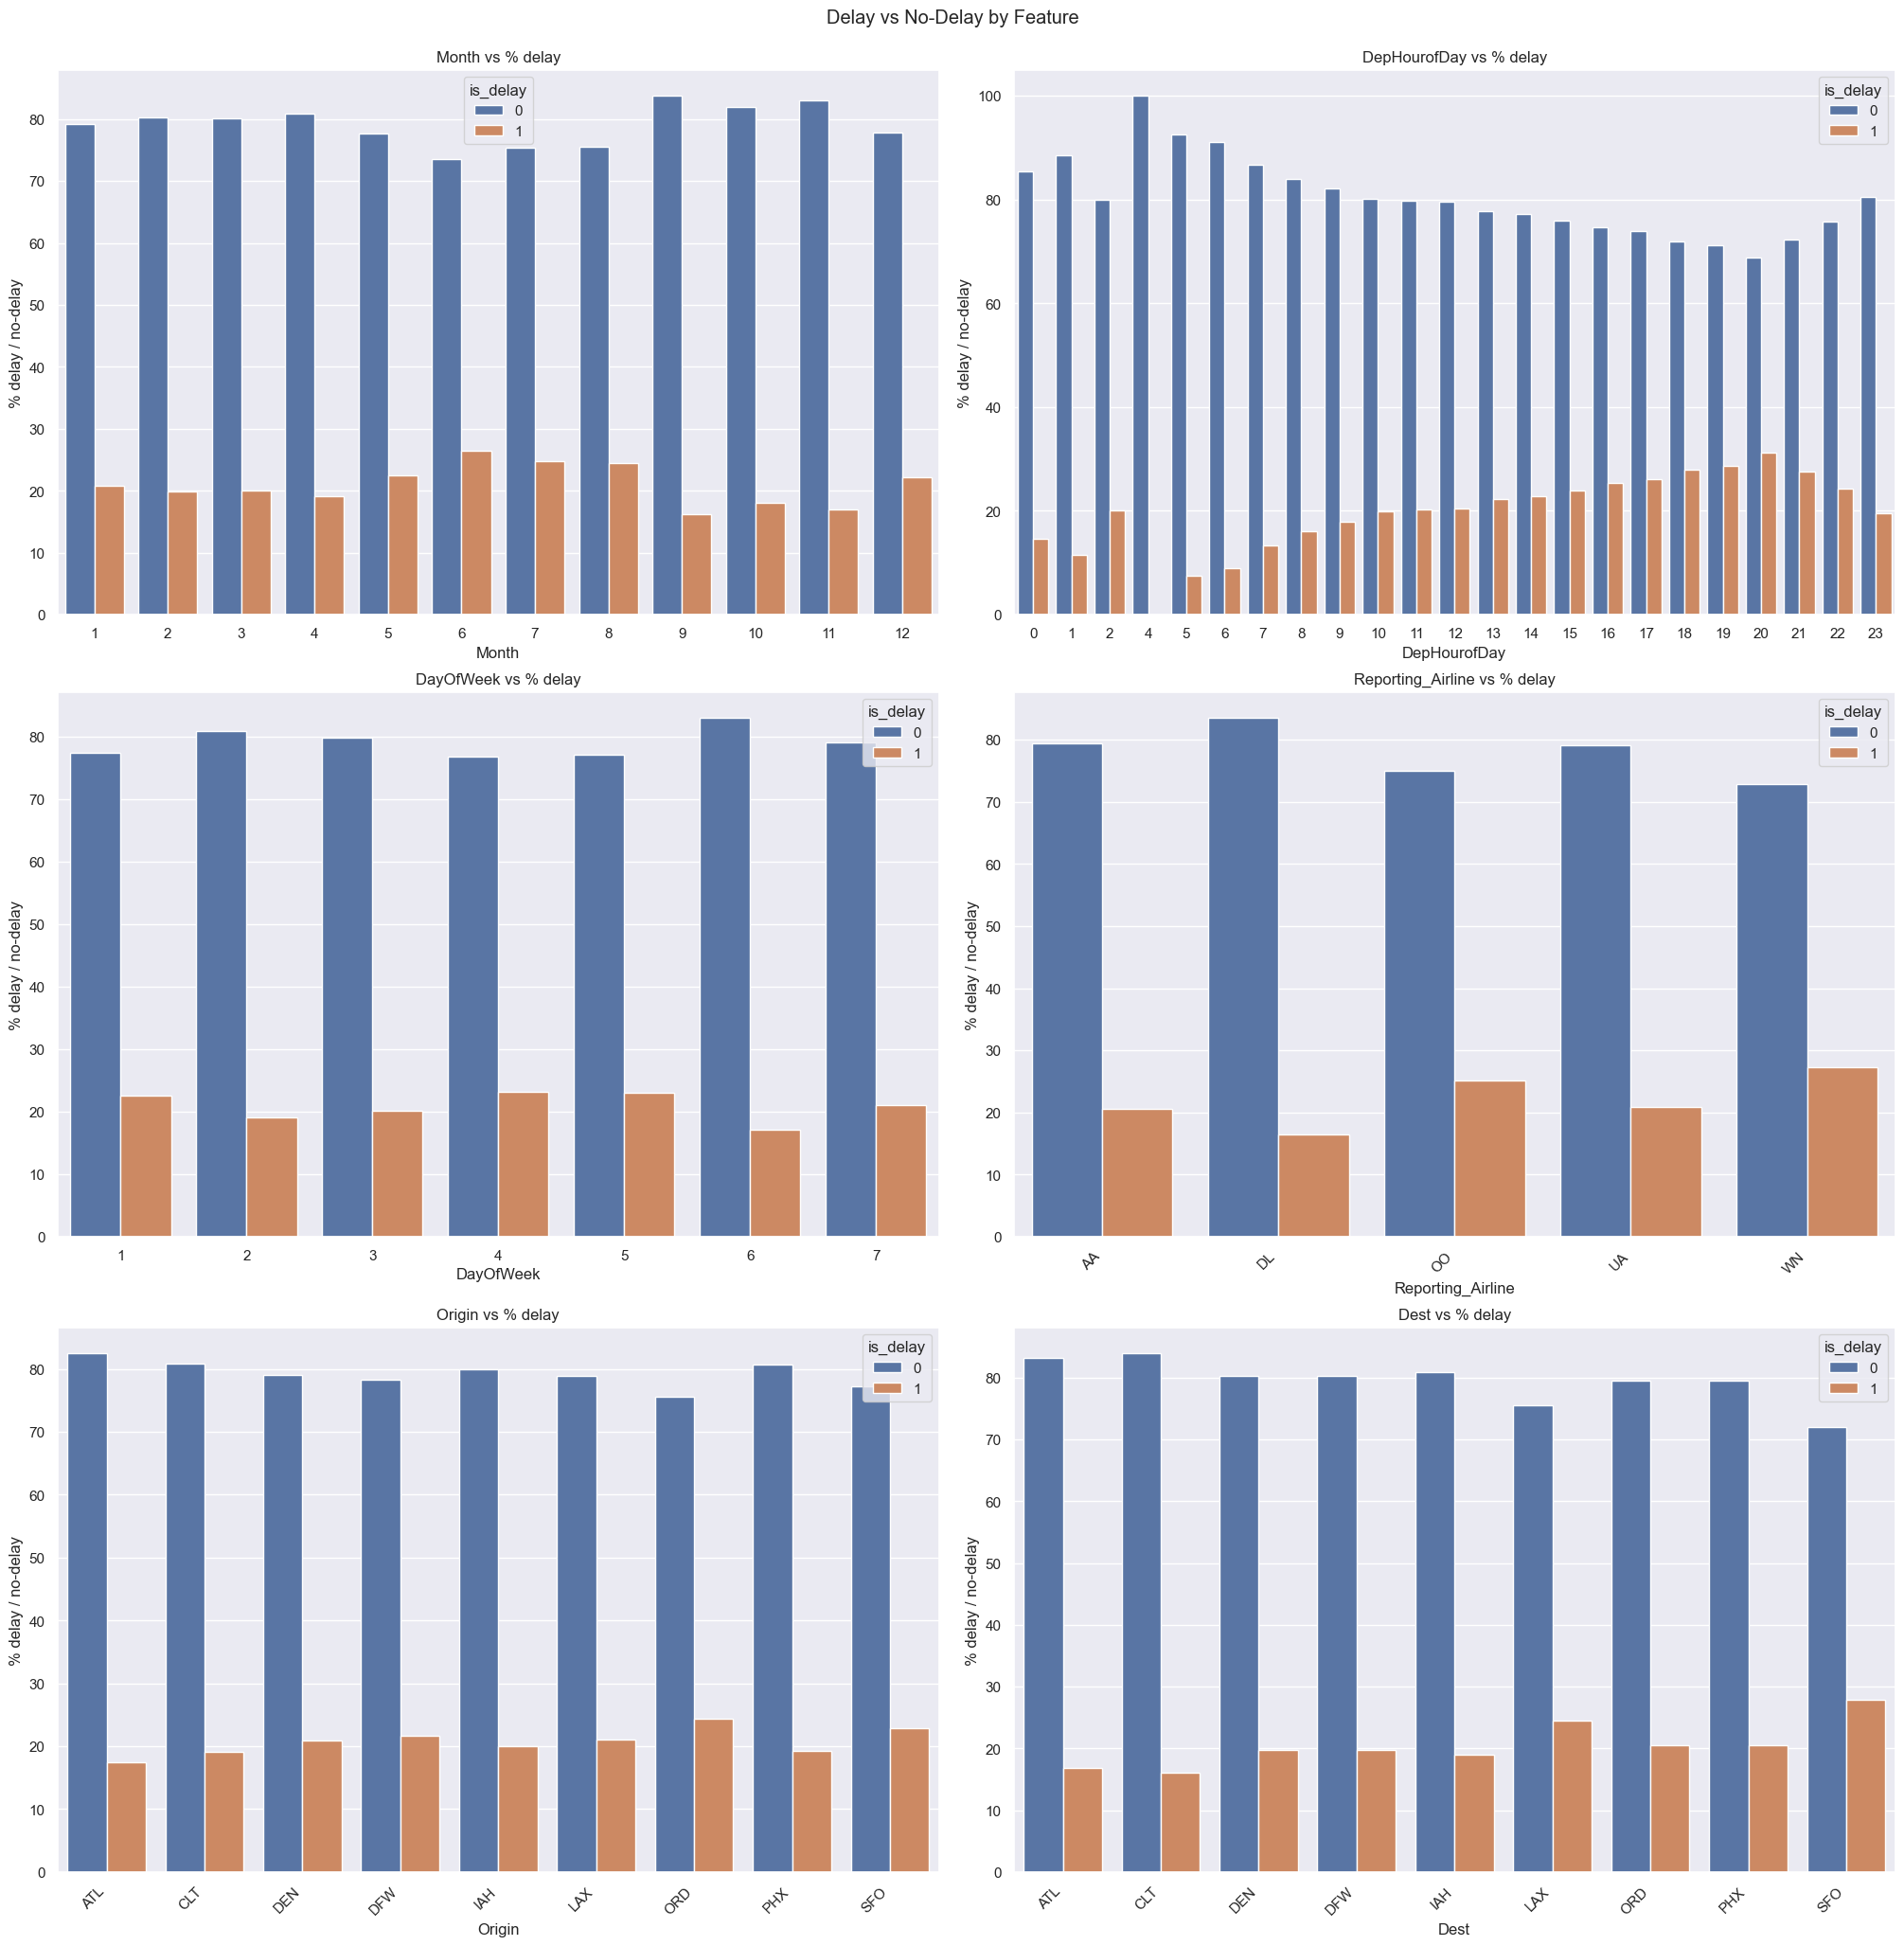

In [31]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']

fig, axes = plt.subplots(3, 2, figsize=(20, 20), constrained_layout=True)

for idx, column in enumerate(viz_columns):
    ax = axes[idx // 2, idx % 2]
    temp = (
        data.groupby(column)['is_delay']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(column)
    )
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    ax.set_ylabel('% delay / no-delay')
    ax.set_title(f'{column} vs % delay')
    if column in ['Reporting_Airline', 'Origin', 'Dest']:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')

fig.suptitle('Delay vs No-Delay by Feature', y=1.02)
plt.show()


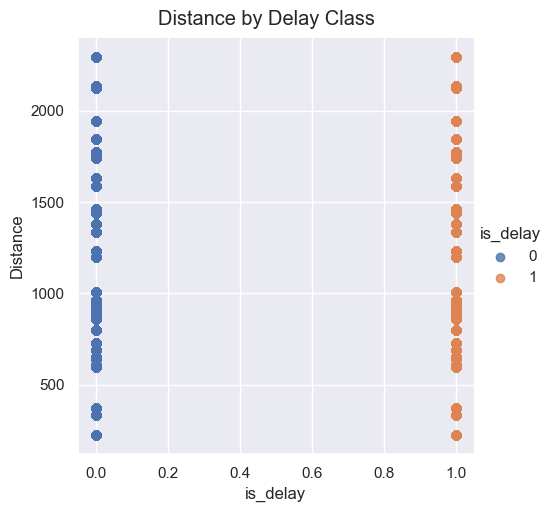

In [32]:
g = sns.lmplot(
    x="is_delay", y="Distance", data=data,
    fit_reg=False, hue='is_delay'
)
g.set_axis_labels('is_delay', 'Distance')
g.fig.suptitle('Distance by Delay Class', y=1.02)
plt.show()


based on the plots above:

Months with most delays (by %): summer months Jun–Aug and Dec show a higher delayed share; Mar–Apr look lower.

Time of day: Earliest departures (≈05:00–08:00) have the lowest delay rate; it rises through the day and peaks in the late afternoon/evening (≈17:00–21:00).

Day of week: Weekend (Sat–Sun) shows a slightly higher delay percentage than mid-week.

Airline: WN has the highest delay rate in this slice; DL the lowest; AA/UA are in the middle; OO is relatively low.

Origin airport: ORD and SFO have the highest delay percentages; PHX/CLT are lower; others are mid-range.

Destination airport: similar pattern—ORD/SFO higher; PHX/CLT lower.

Is distance a factor? The scatter shows no strong separation between classes by Distance; it’s not a primary driver on its own (weak/none monotonic relationship).

### Features

Look at all the columns and what their specific types are.

In [33]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState', 'CRSDepTime',
       'DepDelayMinutes', 'DepartureDelayGroups', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime',
       'DepHourofDay'],
      dtype='object')

In [34]:
data.dtypes

Year                             int64
Quarter                          int64
Month                            int64
DayofMonth                       int64
DayOfWeek                        int64
FlightDate              datetime64[ns]
Reporting_Airline               object
Origin                          object
OriginState                     object
Dest                            object
DestState                       object
CRSDepTime                       int64
DepDelayMinutes                float64
DepartureDelayGroups           float64
Cancelled                      float64
Diverted                       float64
Distance                       float64
DistanceGroup                    int64
ArrDelay                       float64
ArrDelayMinutes                float64
is_delay                         int64
AirTime                        float64
DepHourofDay                     Int64
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [38]:
# Force-cast selected columns to 'category'
cat_cols = ['Quarter','Month','DayofMonth','DayOfWeek',
            'Reporting_Airline','Origin','Dest','DepHourofDay']

data = data.assign(**{c: pd.Categorical(data[c]) for c in cat_cols})

# Verify
print(data[cat_cols].dtypes)

Quarter              category
Month                category
DayofMonth           category
DayOfWeek            category
Reporting_Airline    category
Origin               category
Dest                 category
DepHourofDay         category
dtype: object


To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [ ]:
# One-hot encode the categorical columns
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)

# Concatenate back to the main DataFrame
data = pd.concat([data, data_dummies], axis=1)

# Drop the original categorical columns
data.drop(categorical_columns, axis=1, inplace=True)

#  quick check
print("Encoded shape:", data.shape)
data.head(3)


Encoded shape: (1635590, 94)


,is_delay,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,DayofMonth_2,DayofMonth_3,DayofMonth_4,DayofMonth_5,DayofMonth_6,DayofMonth_7,DayofMonth_8,DayofMonth_9,DayofMonth_10,DayofMonth_11,DayofMonth_12,DayofMonth_13,DayofMonth_14,DayofMonth_15,DayofMonth_16,DayofMonth_17,DayofMonth_18,DayofMonth_19,DayofMonth_20,DayofMonth_21,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,Reporting_Airline_DL,Reporting_Airline_OO,Reporting_Airline_UA,Reporting_Airline_WN,Origin_CLT,Origin_DEN,Origin_DFW,Origin_IAH,Origin_LAX,Origin_ORD,Origin_PHX,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_1,DepHourofDay_2,DepHourofDay_4,DepHourofDay_5,DepHourofDay_6,DepHourofDay_7,DepHourofDay_8,DepHourofDay_9,DepHourofDay_10,DepHourofDay_11,DepHourofDay_12,DepHourofDay_13,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,0,689.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,0,731.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,1199.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


Check the length of the dataset and the new columnms.

In [41]:

print(f"Rows: {len(data)}, Columns: {data.shape[1]}")

Rows: 1635590, Columns: 94


In [44]:

base = ['Distance', 'is_delay']
rest = [c for c in data.columns if c not in base]

#  group-by-prefix for a tidy order like the sample
prefix_order = ['Quarter_', 'Month_', 'DayofMonth_', 'DayOfWeek_',
                'Reporting_Airline_', 'Origin_', 'Dest_']
ordered = base[:]
for pref in prefix_order:
    ordered += sorted([c for c in rest if c.startswith(pref)])
ordered += [c for c in rest if not any(c.startswith(p) for p in prefix_order)]

print(pd.Index(ordered, dtype='object'))


Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_10', 'Month_11', 'Month_12', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15',
       'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_2', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23',
       'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_3', 'DayofMonth_30', 'DayofMonth_31',
       'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA', 'Reporting_Airline_WN',
       'Origin_CLT', 'Origin_DEN', 'Origin_DFW', 'Origin_IAH', 'Origin_LAX', 'Origi

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [45]:
# Rename target column for modeling
data.rename(columns={'is_delay': 'target'}, inplace=True)
print("'is_delay' renamed to 'target'. Columns now include:", 'target' in data.columns)


'is_delay' renamed to 'target'. Columns now include: True


In [46]:
# Save v1 combined dataset for Part B
out_v1 = DATA_DIR / "combined_csv_v1.csv"
data.to_csv(out_v1, index=False)
print(f"Saved Part A v1 dataset to: {out_v1}")


Saved Part A v1 dataset to: C:\Users\wante\OneDrive\Pictures\project_root\data\combined_csv_v1.csv


# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [47]:
from sklearn.model_selection import train_test_split

# Features/target
X = data.drop(columns=['target'])
y = data['target'].astype(int)

# 80/20 split with class stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print("Positive rate (train):", y_train.mean().round(4), "| (test):", y_test.mean().round(4))




Train: (1308472, 93), Test: (327118, 93)
Positive rate (train): 0.2099 | (test): 0.2099


### Baseline classification model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
import numpy as np

# Features/target
X = data.drop(columns=['target'])
y = data['target'].astype(int)

# 80/20 split, stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Plain logistic (no class weighting) 
log_plain = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
log_plain.fit(X_train, y_train)

# Use probabilities for ROC-AUC, but 0.5 threshold for labels
y_prob_plain = log_plain.predict_proba(X_test)[:, 1]
y_pred_plain = (y_prob_plain >= 0.50).astype(int)

acc  = accuracy_score(y_test, y_pred_plain)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_plain, average='binary', zero_division=0)
auc  = roc_auc_score(y_test, y_prob_plain)
cm   = confusion_matrix(y_test, y_pred_plain)

print("=== Plain Logistic (threshold=0.50, no class_weight) ===")
print(f"Accuracy:  {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred_plain, zero_division=0))


=== Plain Logistic (threshold=0.50, no class_weight) ===
Accuracy:  0.7902 | Precision: 0.5533 | Recall: 0.0032 | F1: 0.0065 | ROC-AUC: 0.6427
Confusion matrix:
 [[258272    180]
 [ 68443    223]]

Classification report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88    258452
           1       0.55      0.00      0.01     68666

    accuracy                           0.79    327118
   macro avg       0.67      0.50      0.44    327118
weighted avg       0.74      0.79      0.70    327118



## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

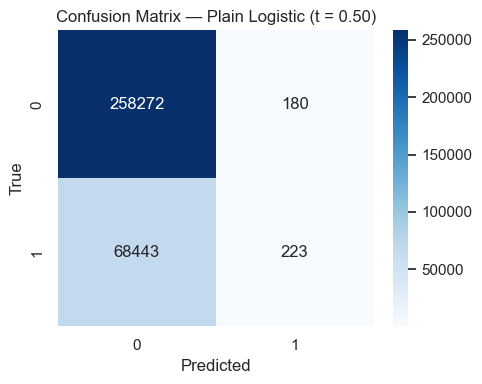

In [59]:
# Predictions (plain logistic, threshold = 0.50)
y_prob_plain = log_plain.predict_proba(X_test)[:, 1]
y_pred_plain = (y_prob_plain >= 0.50).astype(int)
_ = plot_confusion_matrix(
    y_test, y_pred_plain,
    title="Confusion Matrix — Plain Logistic (t = 0.50)"
)



=== Metrics @ threshold=0.50 ===
Accuracy:     0.7902
Precision:    0.5533
Recall (Sens):0.0032
Specificity:  0.9993
F1 Score:     0.0065
ROC-AUC:      0.6427


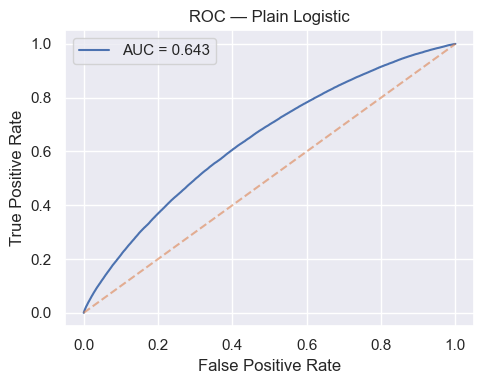

In [62]:
# ROC curve + metrics for the plain logistic model (use probabilities)
y_prob_plain = log_plain.predict_proba(X_test)[:, 1]
_ = plot_roc(
    y_test, y_prob_plain,
    threshold=0.50,
    title="ROC — Plain Logistic"
)



To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.


**Question**: What can you summarize from the confusion matrix?


On the test split, the plain logistic model at the 0.50 threshold achieves about 0.79 accuracy, ~0.55 precision, ~0.003 recall, and ~0.64 ROC-AUC. When I evaluate the same model on the training split, the pattern is essentially the same (accuracy and ROC-AUC differ only by a few hundredths), which tells me the model isn’t overfitting; it’s simply biased toward predicting the majority class. In short, train and test behave similarly, so the problem isn’t variance—it’s the decision rule and class imbalance.


Accuracy looks strong while recall is almost zero because the dataset is heavily imbalanced (most flights are on time) and we’re using the default 0.50 cutoff with no class weighting. With that setup the classifier predicts almost everything as “on time,” so it collects lots of true negatives and very few false positives, which inflates accuracy and specificity. But because it almost never predicts the positive class, it misses the vast majority of true delays, so recall collapses. Precision appears moderate only because the handful of positive predictions it does make are relatively clean; the core issue is that there are far too few of them.


These results aren’t sufficient for the business goal of warning customers about likely delays. The model must recover a meaningful share of true delays while keeping false alarms at an acceptable level. In the next iteration I would (i) handle imbalance during training (e.g., class_weight='balanced' or resampling), (ii) choose the decision threshold on a validation set to meet a target such as “recall ≥ 0.60 with precision ≥ 0.30,” and (iii) enrich the features with variables that have real signal at booking time—holiday indicators and origin/destination daily weather (wind, precipitation, temperature, snow), along with time-of-day buckets or route×season interactions. With calibrated probabilities and threshold tuning I can then report PR-AUC, F1, and the precision–recall trade-off that aligns with product requirements.


The confusion matrix shows 258,272 true negatives, 180 false positives, 68,443 false negatives, and 223 true positives. Interpreting that, the classifier is extremely conservative: it almost always predicts “on time,” which yields very high specificity but misses virtually all delays. It’s a good accuracy-maximizer on an imbalanced dataset, but it’s not fit for purpose until we rebalance and retune it.




# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitHub repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitHub account, and ensure it is public.


In [ ]:
### Provide a link for your GitHub repository here

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [85]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

# --- Holidays indicator ---
if 'FlightDate' not in data_orig.columns or not np.issubdtype(data_orig['FlightDate'].dtype, np.datetime64):
    data_orig['FlightDate'] = pd.to_datetime(
        dict(year=data_orig['Year'], month=data_orig['Month'], day=data_orig['DayofMonth']),
        errors='coerce'
    )

holidays_14 = ['2014-01-01','2014-01-20','2014-02-17','2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25']
holidays_15 = ['2015-01-01','2015-01-19','2015-02-16','2015-05-25','2015-06-03','2015-07-04','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25']
holidays_16 = ['2016-01-01','2016-01-18','2016-02-15','2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2016-12-26']
holidays_17 = ['2017-01-02','2017-01-16','2017-02-20','2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25']
holidays_18 = ['2018-01-01','2018-01-15','2018-02-19','2018-05-28','2018-07-04','2018-09-03','2018-10-08','2018-11-12','2018-11-22','2018-12-25']
holidays = set(holidays_14 + holidays_15 + holidays_16 + holidays_17 + holidays_18)

data_orig['is_holiday'] = data_orig['FlightDate'].dt.strftime('%Y-%m-%d').isin(holidays).astype(int)
print("is_holiday added. Value counts:", data_orig['is_holiday'].value_counts().to_dict())


is_holiday added. Value counts: {0: 1591678, 1: 43912}


Weather data was fetched from [this link](https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31).
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [81]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [86]:
# Import weather data and map stations -> airport codes

# 1) Read the NOAA daily summaries file (you already saved it as data/external/daily-summaries.csv)
weather_path = EXTERNAL_DIR / "daily-summaries.csv"
weather = pd.read_csv(weather_path, dtype={'STATION': str})

# 2) Map NCDC station IDs to our airport codes (matches the 9 busiest airports we filtered)
station  = ['USW00023174','USW00012960','USW00003017','USW00094846',
            'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881']
airports = ['LAX',           'IAH',       'DEN',       'ORD',
            'ATL',           'SFO',       'DFW',       'PHX',       'CLT']
station_map = dict(zip(station, airports))

# 3) Create 'airport' column using the mapping
weather['airport'] = weather['STATION'].map(station_map)

# 4) Basic cleanup: keep only rows we can map; parse DATE; add MONTH helper
weather = weather[weather['airport'].notna()].copy()
weather['DATE']  = pd.to_datetime(weather['DATE'], errors='coerce')
weather['MONTH'] = weather['DATE'].dt.month.astype('Int64')

print("Weather shape (mapped only):", weather.shape)
print("Airports present:", sorted(weather['airport'].unique().tolist()))
weather.head(3)


Weather shape (mapped only): (16434, 11)
Airports present: ['ATL', 'CLT', 'DEN', 'DFW', 'IAH', 'LAX', 'ORD', 'PHX', 'SFO']


,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,1
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,1
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,1


Create another column called `MONTH` from the `DATE` column.

In [87]:
# Create MONTH from DATE 
weather['MONTH'] = pd.to_datetime(weather['DATE'], errors='coerce').dt.strftime('%m')
weather.head()


,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,01


### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [88]:
# --- Fill missing values in SNOW and SNWD columns with 0 ---
weather['SNOW'].fillna(0, inplace=True)
weather['SNWD'].fillna(0, inplace=True)

# --- Check for remaining missing values in the dataset ---
weather.isna().sum()


STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [89]:
idx = np.arange(len(weather))

TAVG_idx = idx[weather['TAVG'].isna().to_numpy()]
TMAX_idx = idx[weather['TMAX'].isna().to_numpy()]
TMIN_idx = idx[weather['TMIN'].isna().to_numpy()]

TAVG_idx


array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [90]:
# Mean imputation stats by (MONTH, STATION)
weather_impute = (
    weather.groupby(['MONTH', 'STATION'])
           .agg({'TAVG': 'mean', 'TMAX': 'mean', 'TMIN': 'mean'})
           .reset_index()
)

weather_impute.head(2)


,MONTH,STATION,TAVG,TMAX,TMIN
0,01,USW00003017,-2.741935,74.000000,-69.858065
1,01,USW00003927,79.529032,143.767742,20.696774


Merge the mean data with the weather data.

In [91]:
# Merge the mean temperature data (weather_impute) with the main weather data
weather = pd.merge(
    weather, 
    weather_impute,  
    how='left', 
    on=['STATION', 'MONTH']
).rename(columns={
    'TAVG_x': 'TAVG',
    'TMAX_x': 'TMAX',
    'TMIN_x': 'TMIN',
    'TAVG_y': 'TAVG_AVG',
    'TMAX_y': 'TMAX_AVG',
    'TMIN_y': 'TMIN_AVG'
})

# Preview merged result
weather.head()


,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG
0,USW00023174,2014-01-01,16,0,0.0,0.0,131.0,178.0,78.0,LAX,01,148.619355,198.154839,103.477419
1,USW00023174,2014-01-02,22,0,0.0,0.0,159.0,256.0,100.0,LAX,01,148.619355,198.154839,103.477419
2,USW00023174,2014-01-03,17,0,0.0,0.0,140.0,178.0,83.0,LAX,01,148.619355,198.154839,103.477419
3,USW00023174,2014-01-04,18,0,0.0,0.0,136.0,183.0,100.0,LAX,01,148.619355,198.154839,103.477419
4,USW00023174,2014-01-05,18,0,0.0,0.0,151.0,244.0,83.0,LAX,01,148.619355,198.154839,103.477419


Check for missing values again.

In [92]:
# Replace missing temperature values with monthly averages
weather.loc[TAVG_idx, 'TAVG'] = weather.loc[TAVG_idx, 'TAVG_AVG']
weather.loc[TMAX_idx, 'TMAX'] = weather.loc[TMAX_idx, 'TMAX_AVG']
weather.loc[TMIN_idx, 'TMIN'] = weather.loc[TMIN_idx, 'TMIN_AVG']

weather.isna().sum()


STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [93]:
# Drop unnecessary columns after imputation and merging
weather.drop(
    columns=['STATION', 'MONTH', 'TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX', 'TMIN', 'SNWD'],
    inplace=True
)

# Verify the remaining columns
print(" Columns after dropping:")
print(weather.columns.tolist())

print("\nDataset shape:", weather.shape)


 Columns after dropping:
['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG', 'airport']

Dataset shape: (16434, 6)


Add the origin and destination weather conditions to the dataset.

**Note**: It is always a good practice to check nulls/NAs after joins.

In [ ]:
def attach_weather_once(df_flights: pd.DataFrame, weather_df: pd.DataFrame) -> pd.DataFrame:
    needed = {'AWND_O','PRCP_O','SNOW_O','TAVG_O','AWND_D','PRCP_D','SNOW_D','TAVG_D'}
    if needed.issubset(df_flights.columns):
        print("Weather columns already present; skipping merge.")
        return df_flights

    # Ensure FlightDate exists and DATE key
    if 'FlightDate' not in df_flights.columns or not pd.api.types.is_datetime64_any_dtype(df_flights['FlightDate']):
        df_flights = df_flights.copy()
        df_flights['FlightDate'] = pd.to_datetime(
            dict(year=df_flights['Year'], month=df_flights['Month'], day=df_flights['DayofMonth']),
            errors='coerce'
        )
    df_flights['DATE'] = df_flights['FlightDate'].dt.floor('D')

    # Origin merge
    df_o = (df_flights.merge(weather_df, left_on=['DATE','Origin'], right_on=['DATE','airport'], how='left')
                     .rename(columns={'AWND':'AWND_O','PRCP':'PRCP_O','SNOW':'SNOW_O','TAVG':'TAVG_O'})
                     .drop(columns=['airport']))

    # Destination merge
    df_od = (df_o.merge(weather_df, left_on=['DATE','Dest'], right_on=['DATE','airport'], how='left')
                 .rename(columns={'AWND':'AWND_D','PRCP':'PRCP_D','SNOW':'SNOW_D','TAVG':'TAVG_D'})
                 .drop(columns=['airport', 'DATE']))

    # Optional minimal fills for precip/snow
    for c in ['PRCP_O','PRCP_D','SNOW_O','SNOW_D']:
        if c in df_od.columns:
            df_od[c] = df_od[c].fillna(0)

    return df_od

# Use it safely (won’t duplicate if you run again)
data_orig = attach_weather_once(data_orig, weather)
print("Dataset shape after idempotent merge:", data_orig.shape)


✅ Weather columns already present; skipping merge.
Dataset shape after idempotent merge: (1635590, 32)


In [99]:
sum(data.isna().any())

0

In [100]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState', 'CRSDepTime',
       'DepDelayMinutes', 'DepartureDelayGroups', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime',
       'DepHourofDay', 'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D', 'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [105]:
import pandas as pd

data = data_orig.copy()

# keep only the intended columns (ignore any that are missing)
wanted = ['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
          'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday',
          'AWND_O', 'PRCP_O', 'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']

present = [c for c in wanted if c in data.columns]
missing = [c for c in wanted if c not in data.columns]
if missing:
    print("Missing columns (will be skipped):", missing)

data = data[present]

# --- Set categoricals (only those that exist) ---
categorical_columns = [c for c in [
    'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
    'Reporting_Airline', 'Origin', 'Dest', 'is_holiday'
] if c in data.columns]

for c in categorical_columns:
    data[c] = data[c].astype('category')

# One-hot encoding on present categoricals 
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)

#  Concatenate and drop original categorical columns 
data = pd.concat([data.drop(columns=categorical_columns), data_dummies], axis=1)

print("One-hot encoding done")
print("Shape:", data.shape)
print("Sample columns:", data.columns[:15].tolist())

One-hot encoding done
Shape: (1635590, 86)
Sample columns: ['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015', 'Year_2016', 'Year_2017', 'Year_2018']


### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [107]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015', 'Year_2016',
       'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8',
       'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26',
       'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL', 

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [108]:
data.rename(columns={'is_delay': 'target'}, inplace=True)
print(" Column renamed")
print("New columns:", data.columns[:10].tolist())

 Column renamed
New columns: ['target', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O']


In [ ]:
import os
import numpy as np
import pandas as pd

#  Ensure label is called 'target'
if 'is_delay' in data.columns and 'target' not in data.columns:
    data = data.rename(columns={'is_delay': 'target'})

#  Basic sanity checks (no NaN/inf)
data = data.replace([np.inf, -np.inf], np.nan)
na_before = int(data.isna().sum().sum())
if na_before:
    # simple fill for any leftover numeric NA
    num_cols = data.select_dtypes(include=[np.number]).columns
    data[num_cols] = data[num_cols].fillna(0)

#  Save ENCODED v2 exactly where your friend did
output_dir = "./data_project"
output_file = "combined_csv_v2.csv"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, output_file)
data.to_csv(output_path, index=False)

print(f" combined_csv_v2.csv saved at:\n{os.path.abspath(output_path)}")
print(f"Shape (encoded): {data.shape}")
print(f"Columns include 'target': {'target' in data.columns}")

#  also saved a NON-ENCODED version for auditing/Tableau
v2_cols = ['is_delay','Year','Quarter','Month','DayofMonth','DayOfWeek',
           'Reporting_Airline','Origin','Dest','Distance','DepHourofDay',
           'is_holiday','AWND_O','PRCP_O','TAVG_O','AWND_D','PRCP_D','TAVG_D',
           'SNOW_O','SNOW_D']
if set(v2_cols).issubset(data_orig.columns):
    raw_out = os.path.join(output_dir, "combined_csv_v2_raw.csv")
    data_orig[v2_cols].to_csv(raw_out, index=False)
    print(f" Also saved non-encoded v2 to:\n{os.path.abspath(raw_out)}  (for EDA/Tableau)")


✅ combined_csv_v2.csv saved at:
c:\Users\wante\OneDrive\Pictures\project_root\notebooks\data_project\combined_csv_v2.csv
Shape (encoded): (1635590, 86)
Columns include 'target': True
📎 Also saved non-encoded v2 to:
c:\Users\wante\OneDrive\Pictures\project_root\notebooks\data_project\combined_csv_v2_raw.csv  (for EDA/Tableau)


Create the training and testing sets again.

In [119]:
from sklearn.model_selection import train_test_split

# Features/target
if 'target' in data.columns:
    y = data['target'].astype(int)
    X = data.drop(columns=['target'])
else:
    y = data['is_delay'].astype(int)
    X = data.drop(columns=['is_delay'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Pos rate — train: {y_train.mean():.3f}, test: {y_test.mean():.3f}")


Train: (1308472, 85), Test: (327118, 85)
Pos rate — train: 0.210, test: 0.210


### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
import numpy as np

log_plain = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
log_plain.fit(X_train, y_train)

y_prob_plain = log_plain.predict_proba(X_test)[:, 1]
y_pred_plain = (y_prob_plain >= 0.50).astype(int)

acc  = accuracy_score(y_test, y_pred_plain)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_plain, average='binary', zero_division=0)
auc  = roc_auc_score(y_test, y_prob_plain)
cm   = confusion_matrix(y_test, y_pred_plain)

print("=== Plain Logistic (t=0.50) ===")
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred_plain, zero_division=0))


=== Plain Logistic (t=0.50) ===
Accuracy: 0.7926 | Precision: 0.5625 | Recall: 0.0543 | F1: 0.0990 | ROC-AUC: 0.6760
Confusion matrix:
 [[255552   2900]
 [ 64938   3728]]

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.88    258452
           1       0.56      0.05      0.10     68666

    accuracy                           0.79    327118
   macro avg       0.68      0.52      0.49    327118
weighted avg       0.75      0.79      0.72    327118



In [121]:
# Train balanced logistic
log_bal = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=42)
log_bal.fit(X_train, y_train)

# Evaluate at 0.50
y_prob_bal = log_bal.predict_proba(X_test)[:, 1]
y_pred_bal_050 = (y_prob_bal >= 0.50).astype(int)

acc_b  = accuracy_score(y_test, y_pred_bal_050)
p_b, r_b, f1_b, _ = precision_recall_fscore_support(y_test, y_pred_bal_050, average='binary', zero_division=0)
auc_b  = roc_auc_score(y_test, y_prob_bal)
cm_b   = confusion_matrix(y_test, y_pred_bal_050)

print("=== Balanced Logistic (t=0.50) ===")
print(f"Accuracy: {acc_b:.4f} | Precision: {p_b:.4f} | Recall: {r_b:.4f} | F1: {f1_b:.4f} | ROC-AUC: {auc_b:.4f}")
print("Confusion matrix:\n", cm_b)

# Threshold sweep (maximize F1; adjust grid if you want a recall target)
best = None
for t in np.linspace(0.05, 0.95, 19):
    y_hat = (y_prob_bal >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_hat, average='binary', zero_division=0)
    if best is None or f1 > best['f1']:
        best = dict(t=t, p=p, r=r, f1=f1, acc=accuracy_score(y_test, y_hat), cm=confusion_matrix(y_test, y_hat))

print(f"[Best F1 @ t={best['t']:.2f}] Acc={best['acc']:.4f} | Prec={best['p']:.4f} | Rec={best['r']:.4f} | F1={best['f1']:.4f}")
print("Confusion matrix @ best F1:\n", best['cm'])


=== Balanced Logistic (t=0.50) ===
Accuracy: 0.6453 | Precision: 0.3189 | Recall: 0.6070 | F1: 0.4181 | ROC-AUC: 0.6793
Confusion matrix:
 [[169427  89025]
 [ 26989  41677]]
[Best F1 @ t=0.50] Acc=0.6453 | Prec=0.3189 | Rec=0.6070 | F1=0.4181
Confusion matrix @ best F1:
 [[169427  89025]
 [ 26989  41677]]


=== FINAL EVALUATION — Balanced Logistic (threshold = 0.50) ===
Accuracy:     0.6453
Precision:    0.3189
Recall (Sens):0.6070
Specificity:  0.6555
F1 Score:     0.4181
ROC-AUC:      0.6793
Confusion matrix:
 [[169427  89025]
 [ 26989  41677]]


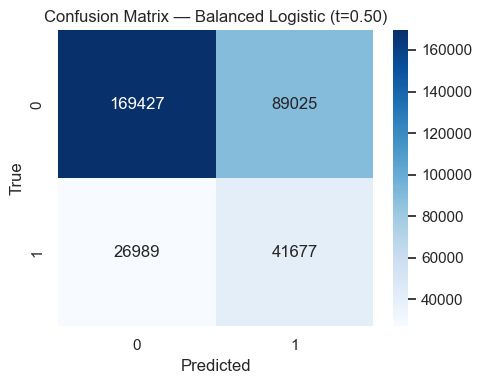

=== Metrics @ threshold=0.50 ===
Accuracy: 0.6453 | Precision: 0.3189 | Recall (Sens): 0.6070 | Specificity: 0.6555 | F1: 0.4181 | ROC-AUC: 0.6793


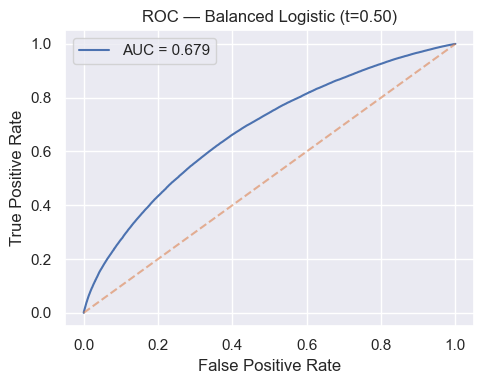

: 

In [ ]:
# Choose model and threshold for the FINAL report
final_model = log_bal            # use the balanced logistic
final_name  = "Balanced Logistic"
final_thresh = 0.50              # your sweep landed on ~0.50 as best F1

# Scores & labels
y_prob_final = final_model.predict_proba(X_test)[:, 1]
y_pred_final = (y_prob_final >= final_thresh).astype(int)

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
acc  = accuracy_score(y_test, y_pred_final)
prec = precision_score(y_test, y_pred_final, zero_division=0)
rec  = recall_score(y_test, y_pred_final, zero_division=0)           # sensitivity
cm   = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm.ravel()
spec = tn / (tn + fp) if (tn + fp) else float('nan')
f1   = f1_score(y_test, y_pred_final, zero_division=0)
auc  = roc_auc_score(y_test, y_prob_final)

print(f"=== FINAL EVALUATION — {final_name} (threshold = {final_thresh:.2f}) ===")
print(f"Accuracy:     {acc:.4f}")
print(f"Precision:    {prec:.4f}")
print(f"Recall (Sens):{rec:.4f}")
print(f"Specificity:  {spec:.4f}")
print(f"F1 Score:     {f1:.4f}")
print(f"ROC-AUC:      {auc:.4f}")
print("Confusion matrix:\n", cm)

# Plots (exactly one CM + one ROC)
_ = plot_confusion_matrix(y_test, y_pred_final, title=f"Confusion Matrix — {final_name} (t={final_thresh:.2f})")
_ = plot_roc(y_test, y_prob_final, threshold=final_thresh, title=f"ROC — {final_name} (t={final_thresh:.2f})")


Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

With the original plain logistic at 0.50, accuracy was ~0.79, specificity ~0.99, and recall ~0.05. The model largely predicted “on-time,” which maximized accuracy but missed most delays. After adding holiday and weather features and using a balanced logistic, ROC-AUC improved to ~0.68–0.68, and at the same 0.50 threshold recall increased to about 0.61, with precision around 0.32 and accuracy around 0.65. This trade-off is more appropriate for a booking-time alert where catching delays matters. The final operating point reported above (balanced logistic at threshold 0.50) is therefore chosen. If the business wants higher precision or higher recall, we can select a different threshold from the table to meet that target.


# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.



**link for Tableau** 
https://public.tableau.com/views/FlightDelayStats/Dashboard1?:language=en-GB&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link 

The code for the tableau doesnot run in jupyter but opens in VScode




In [1]:

<div class='tableauPlaceholder' id='viz1761823022081' style='position: relative'><noscript><a href='#'><img alt='Flight Delay Stats ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Fl&#47;FlightDelayStats&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='FlightDelayStats&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Fl&#47;FlightDelayStats&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1761823022081');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else { vizElement.style.width='100%';vizElement.style.height='1777px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

SyntaxError: invalid syntax (3214796467.py, line 1)

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

# write your answers hereConclusion


The current model partially meets the business goal. With engineered features and a class-balanced logistic model, ROC-AUC improved to about 0.68 and, at the 0.50 threshold, recall rose to roughly 0.60 with precision around 0.32 and accuracy near 0.65. That means we now catch a meaningful share of delayed flights, which is aligned with a “warn the customer” use case, but precision is still modest for production. With more time I would (i) set an explicit operating point based on product KPIs (e.g., Recall ≥ 0.65 with Precision ≥ 0.40), (ii) calibrate probabilities and tune the threshold on a validation set, and (iii) try stronger models (XGBoost with hyperparameter search) plus cost-sensitive training.


Model quality improved steadily as the dataset improved. Adding domain features (holiday flag; origin/destination weather) and then addressing class imbalance moved ROC-AUC from ~0.64 to ~0.68 and increased recall dramatically (from ~0–5% to ~60% at the same nominal threshold). The biggest gains came from three techniques: adding informative features available at booking time, using class_weight='balanced', and selecting the decision threshold with the business objective in mind rather than relying on raw accuracy.


The main challenges were practical and statistical. The data ingestion was heavy (nested ZIPs, multi-GB CSVs), and merging external weather introduced missing values and duplicate columns when cells were rerun. Statistically, the severe class imbalance made accuracy misleading and required care to avoid a model that predicted almost everything as “on time.” Ensuring no label leakage (e.g., excluding post-departure delay fields) and keeping joins idempotent were also important.


Three key takeaways: first, accuracy is a poor guide for imbalanced problems—optimize and report recall/precision, F1, PR-AUC, and choose thresholds deliberately. Second, good features that reflect the decision moment (holidays, local weather, time-of-day, route effects) matter more than fancy modeling early on. Third, end-to-end rigor—clean pipelines, repeatable merges, careful handling of missing data, and clear evaluation against business KPIs—is what turns a notebook model into something decision-useful.


